In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import fasttreeshap
import shap
import pickle
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors
import timeit
from joblib import Parallel, delayed
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
data = pd.read_csv("../data_sets/scaled_annual_data_JFE.csv")
y = data.iloc[:,2]
X = data.iloc[:,3:]
Dates = data.iloc[:,1]

In [ ]:
model = RandomForestRegressor(n_estimators = 100, 
                              max_features = 17,
                              random_state = 1011)
model.fit(X, y)

RandomForestRegressor(max_features=17, random_state=1011)

In [ ]:
explainer = fasttreeshap.TreeExplainer(model, algorithm = "v1", n_jobs = -1)

In [ ]:
""" 
# 并行获取SHAP交互值
start = timeit.default_timer()

def get_shap_interactions(explainer,X,i):
    shap_interaction = explainer(X.iloc[i,:],interactions = True).values
    return shap_interaction

shap_interaction = Parallel(n_jobs=-1)(delayed(get_shap_interactions)(explainer,X,i) for i in range(np.shape(X)[0]))

# 保存SHAP交互值
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # 覆盖任何已有文件
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# 示例用法
save_object(shap_interaction, 'shap_interactions_scaled_vars_RF.pkl')

# 获取变量主效应的SHAP值
shap_values = explainer(X,interactions = False).values

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # 覆盖任何已有文件
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
save_object(shap_values, 'shap_values_scaled_vars_RF.pkl')

stop = timeit.default_timer()
print('耗时: ', stop - start)
"""

" #Get SHAP interaction values in parallel mode\nstart = timeit.default_timer()\n\ndef get_shap_interactions(explainer,X,i):\n    shap_interaction = explainer(X.iloc[i,:],interactions = True).values\n    return shap_interaction\n\nshap_interaction = Parallel(n_jobs=-1)(delayed(get_shap_interactions)(explainer,X,i) for i in range(np.shape(X)[0]))\n\n#save shap interactions\nimport pickle\n\ndef save_object(obj, filename):\n    with open(filename, 'wb') as outp:  # Overwrites any existing file.\n        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)\n\n# sample usage\nsave_object(shap_interaction, 'shap_interactions_scaled_vars_RF.pkl')\n\n# Get SHAP values of variables' main effect\nshap_values = explainer(X,interactions = False).values\n\ndef save_object(obj, filename):\n    with open(filename, 'wb') as outp:  # Overwrites any existing file.\n        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)\n        \nsave_object(shap_values, 'shap_values_scaled_vars_RF.pkl')\n\nstop = timeit.d

#### SHAP time evolution

In [ ]:
# 加载已保存的各变量主效应的Shapley值
with open('shap_values_scaled_vars_RF.pkl', 'rb') as f:
    # 协议版本会自动检测，无需手动指定
    shap_values = pickle.load(f)

In [6]:
Dates = pd.Series(Dates, name='Dates')
df_shapley_annual = pd.concat([Dates, pd.DataFrame(shap_values,columns=X.columns)],axis=1)
df_shapley_annual['Dates'] = pd.to_datetime(df_shapley_annual['Dates'], format='%Y%m')

In [7]:
abs_mean_df = df_shapley_annual.groupby(df_shapley_annual['Dates'].dt.year).apply(lambda x: x.iloc[:,1:].abs().mean()).reset_index()
abs_mean_df.set_index('Dates', inplace=True)

In [8]:
abs_mean_norm_df = (abs_mean_df - abs_mean_df.min(axis=1).values.reshape(-1,1)) / (abs_mean_df.max(axis=1) - abs_mean_df.min(axis=1)).values.reshape(-1,1)
abs_mean_norm_df = abs_mean_norm_df * 100

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


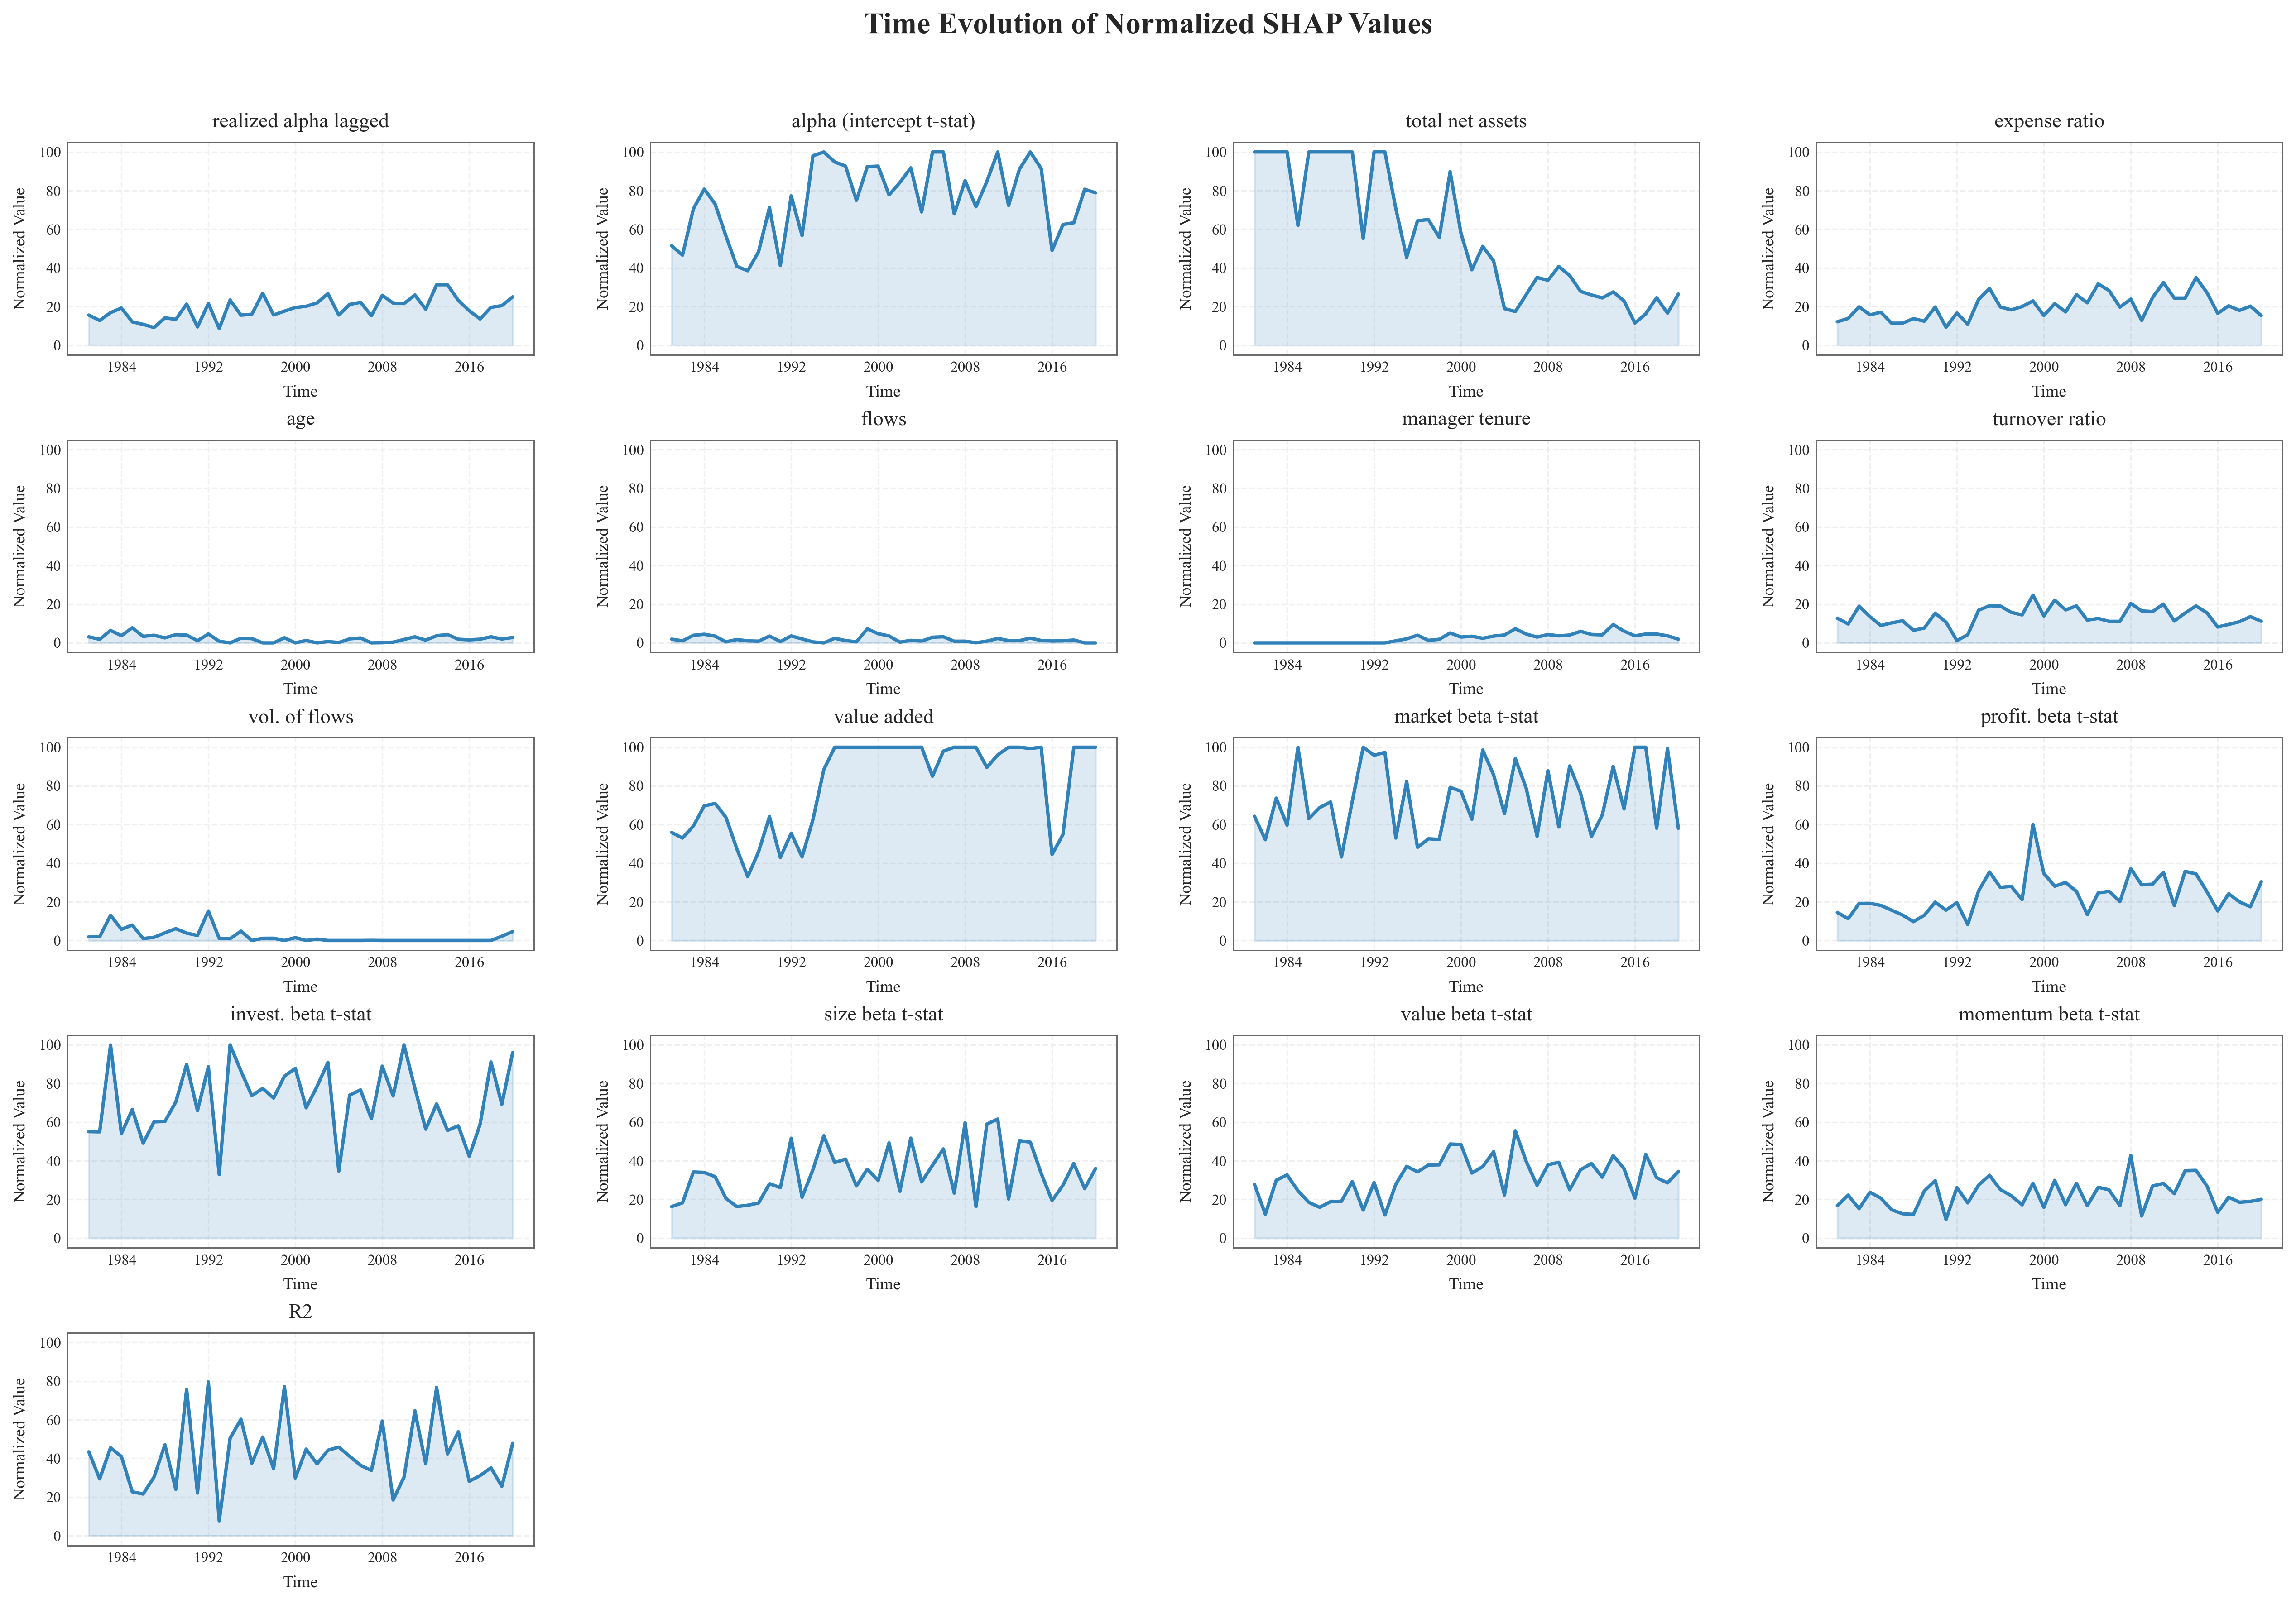

In [ ]:
abs_mean_norm_df = (abs_mean_df - abs_mean_df.min(axis=1).values.reshape(-1,1)) / (abs_mean_df.max(axis=1) - abs_mean_df.min(axis=1)).values.reshape(-1,1)
abs_mean_norm_df = abs_mean_norm_df * 100

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'grid.color': '0.92',
    'grid.linestyle': '--',
    'axes.edgecolor': '0.2',
    'axes.linewidth': 0.8
})

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(17, 12), dpi=300)
axes = axes.flatten()

fig.suptitle('Time Evolution of Normalized SHAP Values', 
             fontsize=16, y=0.98, fontweight='bold')

for i, ax in enumerate(axes):
    if i < abs_mean_norm_df.shape[1]:
        line = abs_mean_norm_df.iloc[:, i].plot(
            ax=ax, 
            ylim=(-5, 105), 
            color="#1f77b4",
            linewidth=1.8,
            alpha=0.9
        )
        
        ax.fill_between(
            abs_mean_norm_df.index,
            abs_mean_norm_df.iloc[:, i],
            alpha=0.15,
            color="#1f77b4"
        )
        
        ax.set_title(
            abs_mean_norm_df.columns[i], 
            fontsize=11, 
            pad=8, 
            fontweight='medium'
        )
        ax.set_xlabel("Time", fontsize=9, labelpad=5)
        ax.set_ylabel("Normalized Value", fontsize=9, labelpad=5)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
        
        for spine in ax.spines.values():
            spine.set_color('0.4')
            spine.set_linewidth(0.7)
    else:
        fig.delaxes(ax)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4, wspace=0.25)

plt.savefig(
    "time_evolution_SHAP_RF.pdf",
    format="pdf", 
    bbox_inches="tight",
    dpi=300,
    facecolor='white',
    edgecolor='none'
)

plt.show()